# Assignment A2
## Task1.a: a function that computes R-squared added to the LinearRegression class.
## Task1.b: Based on the formula that is given in the assignment, Xavier methid to set an initial weight added as weight parameter in the class. 
## Task1.c: a momentum parameter added to the class with values 0 and 0.9.
## Task1.d: ..... so sorry!
## Task2.a: for this task I fitted 14 different models with different set of parameters. However analyzing these number of model could be complicated and non informative but in this case the consistent pattern could be observed. an excell file and some graphs of this comparisons is put in the folder. in a nutshell increasing learning rate had a severe impact on the result. the metrics skyrocketed when lr set to smaller value. among methods mini batch had better result comparing batch and stochastic(for stochastic I faced an issue in the codes and I used the program in mini batch and batch size = 1, I am not sure that it is correct or not), normal and lasso had better result with respect to R2 and mse but all models had terrible result with lr = .001 and lr = 0.0001 (?). 
## Task2.b: by analyzing r2 and mse in different models, I chose the simplest one which had small mse and large r2 at the same time (mse =0.119 and r2 = 0.83)
## Task2.c: short report
## Task3: Deploy, Finally I could deploy a model into the web. At the very last time I encountered an error in my saved model so I deploy my previous model just to show that I have tried to learn this part.
note: Because of long time of each run I had to chose epoch = 100 and kfolds = 2,  I know these are not proper values. I ran the codes more about 50 times or so.
I attached some graphs in the notebook but not sure that it is visible. please accept my appologies. 


this is metric values for selected model
![Alt text](<Screenshot 2023-09-15 202438.png>)

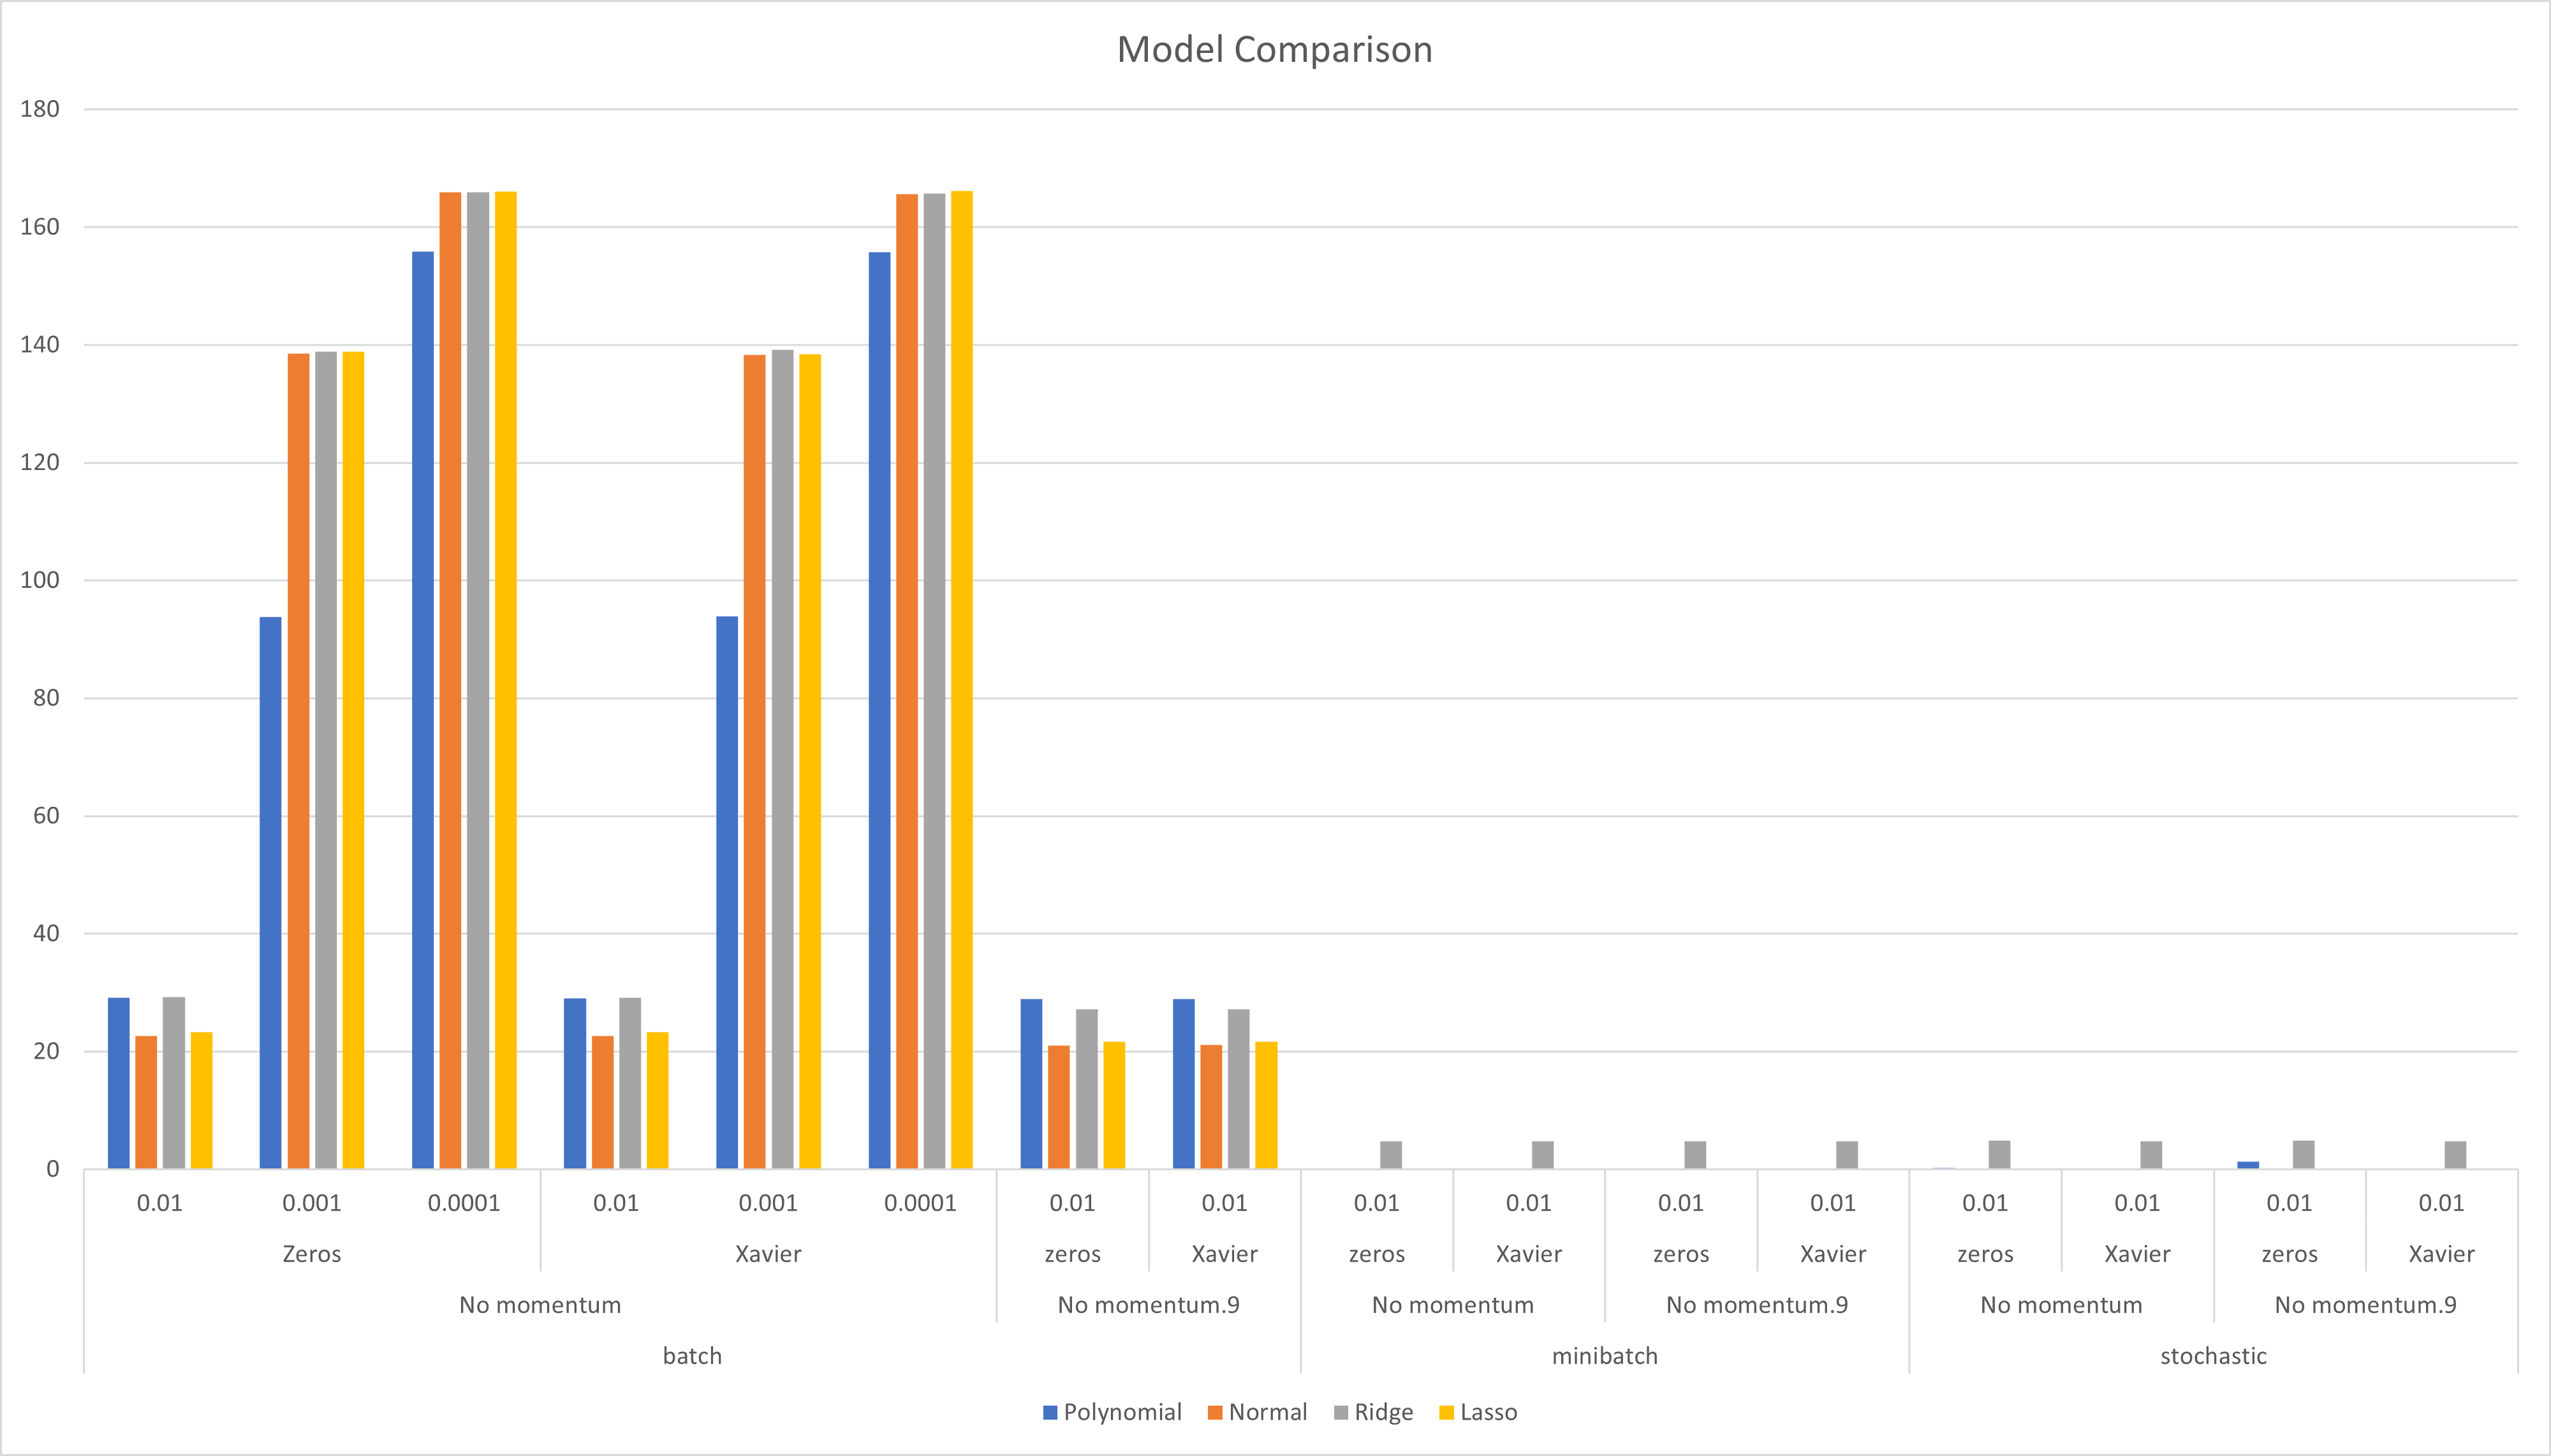

Models in MLFLOW:
![Screenshot 2023-09-15 080053.png](<attachment:Screenshot 2023-09-15 080053.png>)
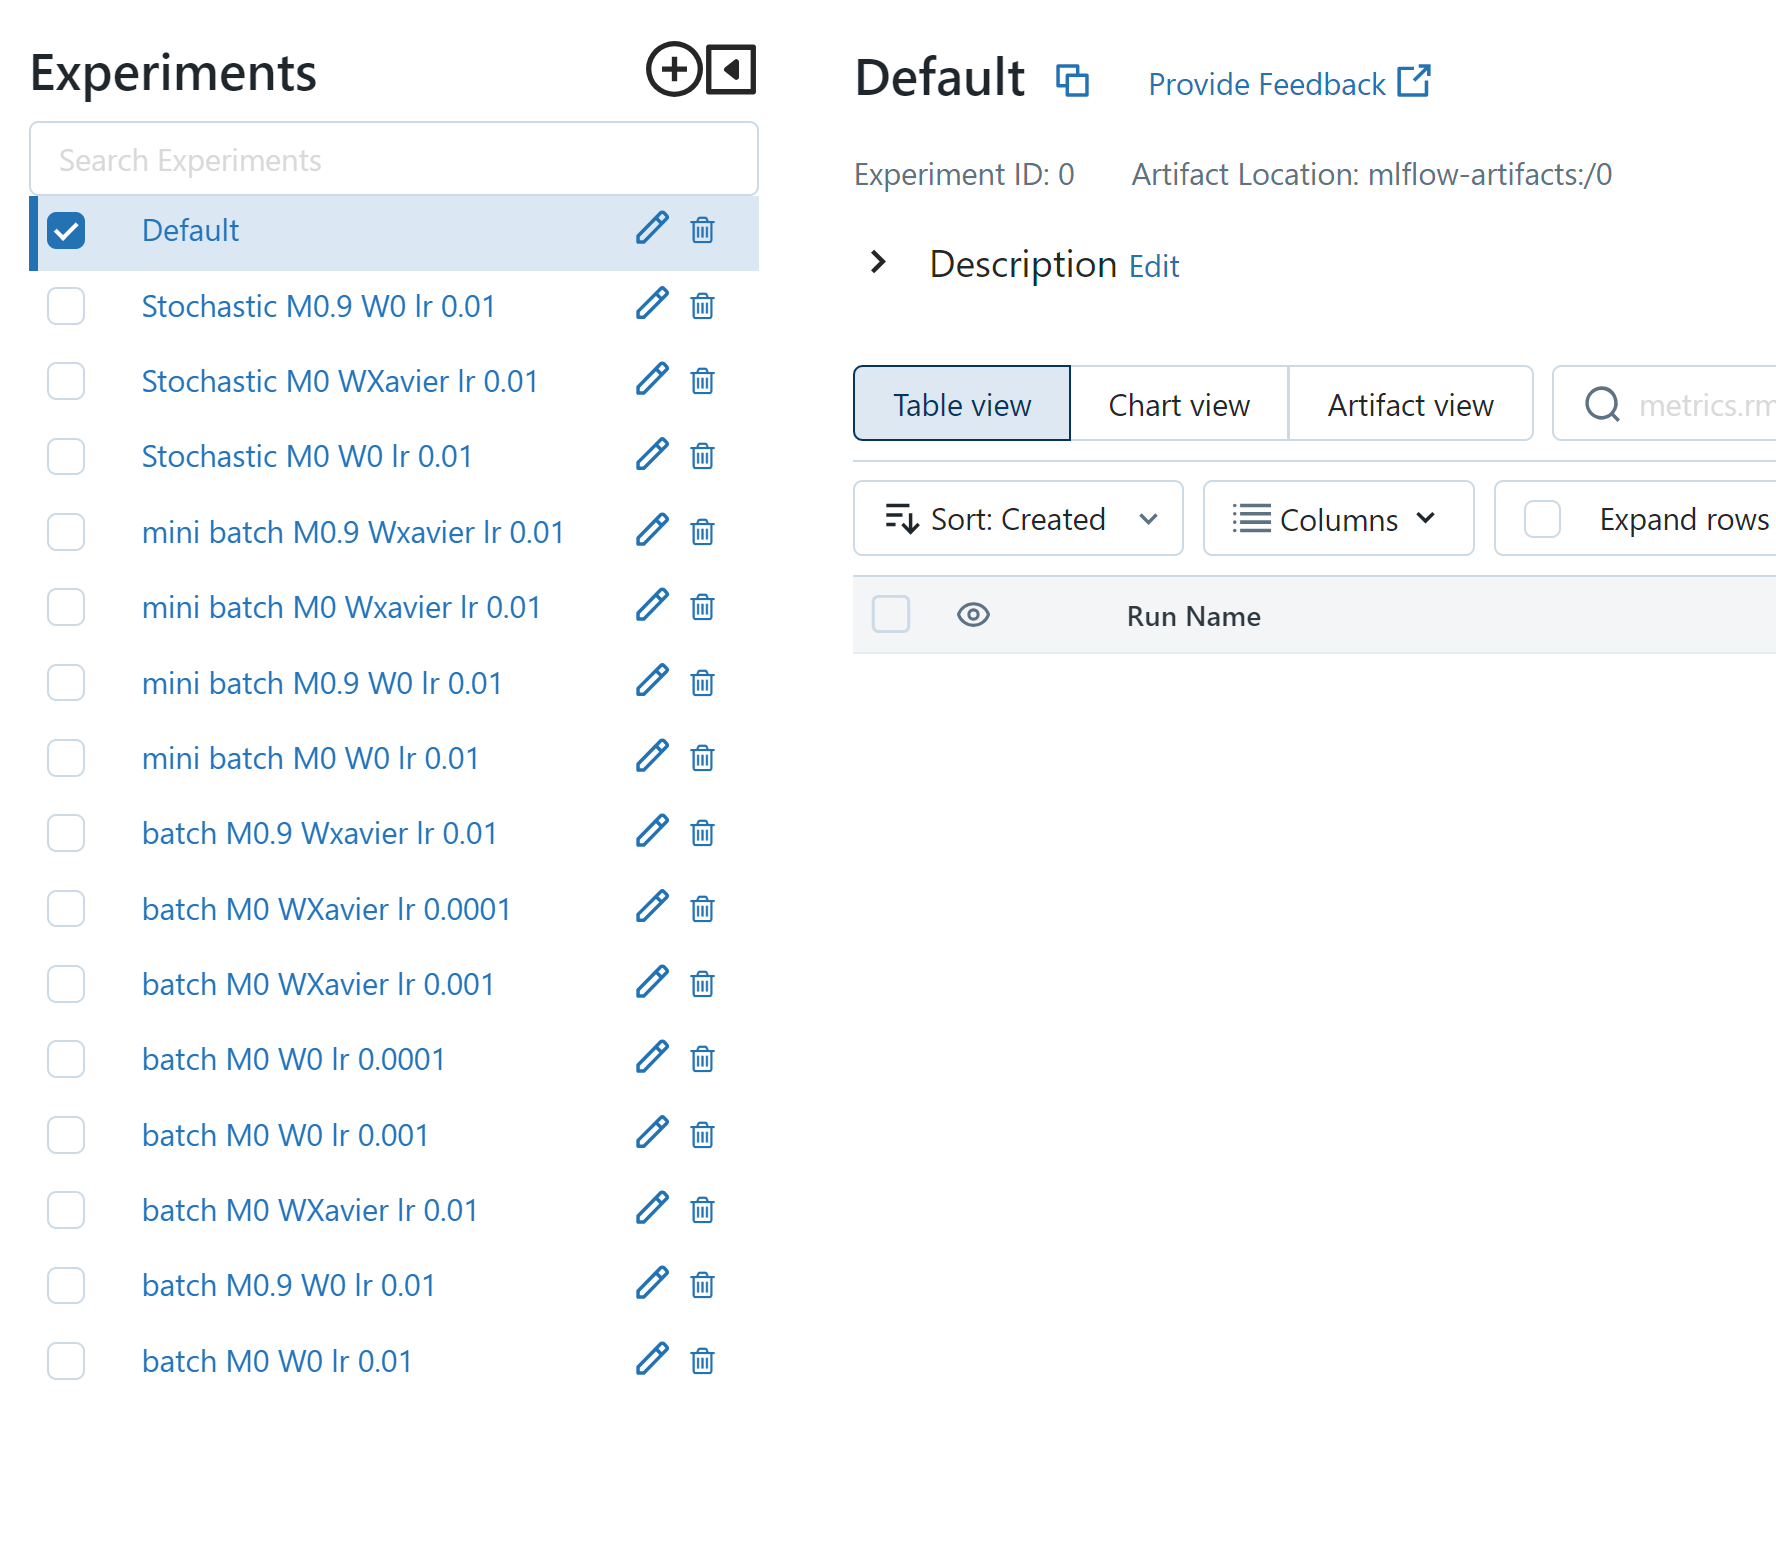

comparison of Normal, Polynomial, Lasso and Ridge:
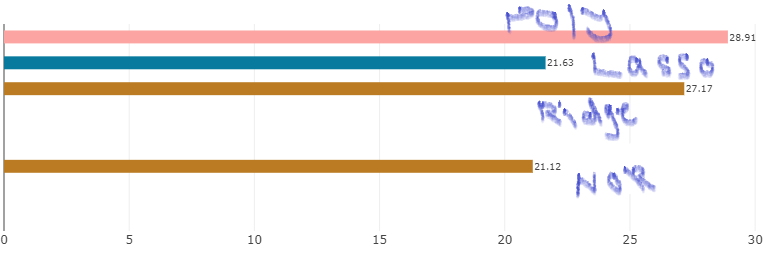

Momentum Comparison, yellow is zero.
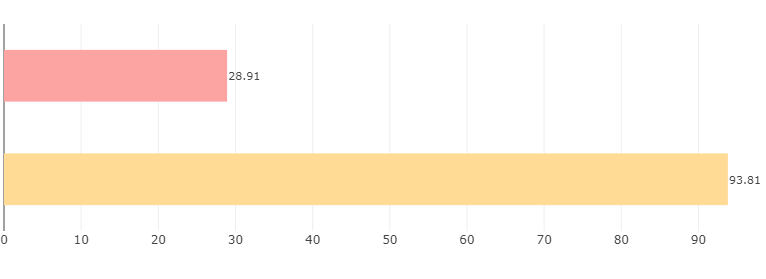

In [ ]:
#experiment tracking
import mlflow
import os
# This the dockerized method.
# We build two docker containers, one for python/jupyter and another for mlflow.
# The url `mlflow` is resolved into another container within the same composer.
mlflow.set_tracking_uri("http://mlflow:5000")
# In the dockerized way, the user who runs this code will be `root`.
# The MLflow will also log the run user_id as `root`.
# To change that, we need to set this environ["LOGNAME"] to your name.
os.environ["LOGNAME"] = "reza370"
mlflow.create_experiment(name="Stochastic M0.9 WXavier lr 0.01")  #create if you haven't create
mlflow.set_experiment(experiment_name="Stochastic M0.9 WXavier lr 0.01")

In [ ]:
import pandas as pd
df_cars=pd.read_csv('Cars.csv')
owner_coding = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
df_cars['owner'] = df_cars['owner'].map(owner_coding)
#2
df_cars = df_cars[df_cars['fuel'].isin(['Petrol', 'Diesel'])]
#3
df_cars.mileage = df_cars.mileage.str.split(expand=True)[0].astype(float)
#4
df_cars.engine = df_cars.engine.str.split(expand=True)[0].astype(float)
#5
df_cars.loc[df_cars['max_power'] == 'bph', 'max_power'] = ' bph'
df_cars.max_power = df_cars.max_power.str.split(expand=True)[0].astype(float)
#6
df_cars.name=df_cars.name.str.split(expand=True)[0]
#7
df_cars = df_cars.drop(columns=['torque'])
#8
df_cars = df_cars[df_cars['owner'] != 5]
#9
import numpy as np
df_cars['selling_price'] = np.log(df_cars['selling_price'])
from datetime import datetime
now = datetime.now()
df_cars['car_age'] = int(now.strftime("%Y")) - df_cars['year']


In [ ]:
df_cars.head()

In [ ]:
X = df_cars[['max_power', 'mileage', 'car_age']]
y = df_cars['selling_price']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 370)
X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_train['mileage'].fillna(X_train['mileage'].mean(), inplace=True)
X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_test['mileage'].fillna(X_train['mileage'].mean(), inplace=True)

In [ ]:
X_train.head()

In [ ]:
feature_names = ['max_power', 'mileage', 'car_age']
label_name = 'selling_price'
from   sklearn.preprocessing import StandardScaler
from   sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from   time import time
import pandas as pd
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test  = scaler.transform(X_test)
X_train = np.insert(X_train, 0, 1, axis=1)
X_test  = np.insert(X_test, 0, 1, axis=1)
y_train = np.array(y_train)
y_test  = np.array(y_test)
poly_X_train = PolynomialFeatures(degree = 2, include_bias=False).fit_transform(X_train)[:, [4,5,6,7,8,9,10,11,12,13]]
poly_X_test = PolynomialFeatures(degree = 2, include_bias=False).fit_transform(X_test)[:, [4,5,6,7,8,9,10,11,12,13]]
X_train.shape, X_test.shape, y_train.shape, y_test.shape,  poly_X_test.shape

In [ ]:
pd.DataFrame(poly_X_train)

In [ ]:
from sklearn.model_selection import KFold

class LinearRegression(object):
    
    kfold = KFold(n_splits=2)
            
    def __init__(self, regularization, lr=0.001, method='batch', num_epochs=100, batch_size=1, cv=kfold, weight_init = 'xavier', momentum = 0.9):
        self.lr             = lr
        self.num_epochs     = num_epochs
        self.batch_size     = batch_size
        self.method         = method
        self.cv             = cv
        self.weight_init    = weight_init
        self.momentum       = momentum
        self.regularization = regularization
        self.prev_grad      = None  

    def mse(self, ytrue, ypred):
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
    
    #:::::::::::::::Assignment 2, Task1.1:Add a function r2 that compute the r2score.:::::::::::::
    def r_squared(self, y_true, y_pred):
        ss_residual = ((y_pred - y_true) ** 2).sum()
        ss_total = (((y_true) - np.mean(y_true)) ** 2).sum()
        r2 = 1 - (ss_residual / ss_total)
        return r2
    
    def fit(self, X_train, y_train):
            
        #create a list of kfold scores
        self.kfold_scores = list()
        
        #reset val loss
        self.val_loss_old = np.infty

        #kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
                   
    #::::::::::::::Assignment 2, Task1.2: Modify the class such that it allows the user to choose between zeros initialization or xavier.::::::::::::::

            # "Xavier/Glorot" or "zero" initialization
            if self.weight_init == 'xavier':
                limit = np.sqrt(1 / (X_cross_train.shape[0]))
                self.theta = np.random.uniform(-limit, limit, size=X_cross_train.shape[1])
            if self.weight_init == 'zeros':
                self.theta = np.zeros(X_cross_train.shape[1])
                              
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50

                     
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__, "initial weight":self.weight_init}
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    X_cross_train = X_cross_train[perm]
                    y_cross_train = y_cross_train[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                            y_method_train = y_cross_train[batch_idx] 
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)
                    else:
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    #val_loss_new = self.r_squared(y_cross_val, yhat_val)
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    
                    #record dataset
                    #mlflow_train_data = mlflow.data.from_numpy(features=X_method_train, targets=y_method_train)
                    #mlflow.log_input(mlflow_train_data, context="training")
                    
                    #mlflow_val_data = mlflow.data.from_numpy(features=X_cross_val, targets=y_cross_val)
                    #mlflow.log_input(mlflow_val_data, context="validation")
                    
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                print(f"Fold {fold}: {val_loss_new}")
    
        
                    
    def _train(self, X, y):
                    
        yhat = self.predict(X)
        m    = X.shape[0]        
        grad = (1/m) * X.T @(yhat - y) + self.regularization.derivation(self.theta)
        
        #::::::::::::::Assignment 2, Task1.3: Modify the class such that it allows the user to choose momentum.::::::::::::::
      
        if self.prev_grad is None:
            self.prev_grad = np.zeros_like(self.theta)  # Initialize velocity if it's None

        # Update the velocity using momentum
        self.prev_grad = self.momentum * self.prev_grad + (1 - self.momentum) * grad

        # Update the parameters using the prev_grad and learning rate
        self.theta = self.theta - self.lr * self.prev_grad
        return self.mse(y, yhat) 
           
        
        #self.theta = self.theta - self.lr * grad
        #return self.mse(y, yhat)
        #return self.r_squared(y, yhat)

    import matplotlib.pyplot as plt
    def plot_feature_importance(self, feature_names):
        # Create a list of tuples with feature names and coefficients
        feature_coef = [(name, coef) for name, coef in zip(feature_names, self.theta)]

        # Sort the list by coefficient magnitude
        feature_coef.sort(key=lambda x: abs(X_train[1]), reverse=True)

        # Extract sorted feature names and coefficients
        sorted_feature_names, sorted_coefficients = zip(*feature_coef)

        # Create a horizontal bar plot
        plt.figure(figsize=(10, 6))
        plt.barh(sorted_feature_names, sorted_coefficients, color='b')
        plt.xlabel('Coefficient Magnitude')
        plt.title('Feature Importance Based on Coefficients')
        plt.gca().invert_yaxis()  # Invert the y-axis for better readability
        plt.show()

   
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]

In [ ]:
X_train

In [ ]:
class Normalpenalty:
    def __init__(self, l):
        self.l = 0 # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)

class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, theta):  #__call__ allows us to call class as method
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(theta))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(theta))
        return (l1_contribution + l2_contribution)

    def derivation(self, theta):
        l1_derivation = self.l * self.l_ratio * np.sign(theta)
        l2_derivation = self.l * (1 - self.l_ratio) * theta
        return (l1_derivation + l2_derivation)

class Normal(LinearRegression):
    def __init__(self, method, lr, l):
        self.regularization = Normalpenalty(l)
        super().__init__(self.regularization, lr, method)

class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, method)
        
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, method)
        
class ElasticNet(LinearRegression):
    
    def __init__(self, method, lr, l, l_ratio=0.5):
        self.regularization = ElasticPenalty(l, l_ratio)
        super().__init__(self.regularization, lr, method)


In [ ]:
#helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [ ]:
regs = ["Normal"]   #Polynomial

for reg in regs:

    params = {"method": "mini", "lr": 0.01, "l": 0}
    mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{'polynomial'}-weight_init-{'Xavier'}-momentum{'0.9'}", nested=True)
    print("*"*5, "Polynomial", "*"*5)
     # #######
    type_of_regression = str_to_class(reg)    
    model = type_of_regression(**params)
    model.fit(poly_X_train, y_train)
    yhat = model.predict(poly_X_test)
    mse  = model.mse(yhat, y_test)
    r_squared = model.r_squared(y_test, yhat)
    print("Test mse: ", mse)
    mlflow.log_metric(key="mse", value=mse)
    print("Test R2: ", r_squared)
    
    
    mlflow.log_metric(key="r_squared", value=r_squared)
    signature = mlflow.models.infer_signature(poly_X_train, model.predict(poly_X_train))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)


In [ ]:
regs = ["Normal", "Ridge", "Lasso"]

for reg in regs:

    params = {"method": "mini", "lr": 0.01, "l": 0.1}
    mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-weight_init-{'Xavier'}-momentum{'0.9'}", nested=True)
    print("*"*5, reg, "*"*5)
     # #######
    type_of_regression = str_to_class(reg)    #Normal, Ridge, Lasso
    model = type_of_regression(**params)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    mse  = model.mse(yhat, y_test)
    r_squared = model.r_squared(y_test, yhat)
    print("Test mse: ", mse)
    mlflow.log_metric(key="mse", value=mse)
    print("Test R2: ", r_squared)

    
    mlflow.log_metric(key="r_squared", value=r_squared)
    signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()